In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import random
from scipy.optimize import minimize
from numpy import array
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings("ignore")

# Read metadata

In [37]:
df_meta = pd.read_csv('../../our_data/meta_data.csv', index_col=0)
df_scfa = pd.read_csv('../../our_data/SCFA.csv', index_col=0)
df_meta_scfa = pd.merge(df_meta, df_scfa, left_index=True, right_index=True, how='inner')
df_meta_scfa.head()

,MiceID,Vendor,Day,Diet,RandomizedGroup,Acetate,Propionate,Butyrate,Total
SampleID,,,,,,,,,
sample131,BC1,Beijing,0,Control,C,20.205741,3.297966,2.729283,26.741973
sample132,BC2,Beijing,0,Control,B,15.789550,2.520570,2.439410,21.178312
sample133,BC3,Beijing,0,Control,A,25.064928,5.569482,2.176445,34.101622
sample134,BC4,Beijing,0,Control,D,16.980939,3.224844,2.513462,23.310672
sample135,BC5,Beijing,0,Control,E,21.801265,4.224119,3.107713,29.891000


# Fit harmonic oscillator model (for each SCFA and each mice)

In [38]:
def overdampling(params,xdata):
    k1,k2,D,H,Ai = params
    ypred = H/k1/k2+((D+k2*Ai-H/k1)*np.exp(-k1*xdata)-(D+k1*Ai-H/k2)*np.exp(-k2*xdata))/(k2-k1)
    return ypred

In [39]:
def residual(params,xdata,ydata):
    ypred = overdampling(params,xdata)
    return -r2_score(ydata, ypred)

## inulin

In [40]:
df_meta_scfa_inulin = df_meta_scfa[df_meta_scfa.Diet=='Inulin']
all_mice = list(set(df_meta_scfa_inulin.MiceID))
initial_condition = 'fixedIC' # free initial condition or fixed initial condition

lines = []
for i, scfa_ in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j, mice_ in enumerate(all_mice):
        curr_df = df_meta_scfa_inulin[df_meta_scfa_inulin.MiceID==mice_].sort_values(by='Day')
        vendor_ = list(set(curr_df.Vendor))[0]
        
        # get X and Y data
        xdata = np.array(curr_df.Day)
        ydata = np.array(curr_df[scfa_])

        # model fitting
        min_obj_over = 1e10
        best_sol_over = None
        trial=0
        while trial < 100:
            try:
                if initial_condition=='freeIC':
                    res = minimize(residual, 
                                   [random(),random(),random(),random(),random()], 
                                   args=(xdata,ydata),
                                   bounds = ((0, 1), (0, 1), (0, None), (0, None), (0,None)),
                                   method='Powell', # Powell
                                   tol=1e-8,
                                   options={'maxiter':1000}
                                  )
                elif initial_condition=='fixedIC':
                    res = minimize(residual, 
                       [random(),random(),random(),random(),ydata[0]], 
                       args=(xdata,ydata),
                       bounds = ((0, 1), (0, 1), (0, None), (0, None), (ydata[0],ydata[0])),
                       method='Powell', # Powell
                       tol=1e-8,
                       options={'maxiter':1000}
                      )
                else:
                    print('unknown initial condition: %s'%(initial_condition))
                    raise
                assert res.success==True
                if res.fun < min_obj_over:
                    best_sol_over = res.x
                    min_obj_over = res.fun
                trial += 1
            except:
                pass
        print(scfa_, mice_)
        print(best_sol_over)
        lines.append([mice_, vendor_, scfa_] + list(best_sol_over) + [r2_score(ydata, overdampling(best_sol_over, xdata))])

    # write to file
    df_best_fit = pd.DataFrame(lines, columns=['MiceID','Vendor','SCFA','k1','k2','D','H','Ai','R2'])
    df_best_fit['zeta'] = [(k1+k2)/2/np.sqrt(k1*k2) for k1,k2 in zip(df_best_fit['k1'],df_best_fit['k2'])]
    df_best_fit.to_excel('best_fit_parameters_inulin_r2_%s.xlsx'%(initial_condition))

Acetate GI4
[0.03023044 0.28954908 7.93554741 0.0167699  8.4866322 ]
Acetate GI3
[ 0.42694985  0.4269503  18.90834302  3.73490798  8.6126283 ]
Acetate BI1
[ 0.57480079  0.57480041 23.76109175  5.38860023  5.23389922]
Acetate HI5
[ 0.23522746  0.23522739  4.65063896  0.66296165 13.79321843]
Acetate HI2
[ 0.39003852  0.39003865 15.52487899  2.13348848  2.06124266]
Acetate SI1
[ 0.22256115  0.22256115 17.03300103  0.37051636  3.65146118]
Acetate SI4
[ 0.0784891   1.         18.87516684  0.86393623  7.91718273]
Acetate SI5
[ 0.2899772   0.28997721  7.6953416   1.12961841 10.29078305]
Acetate HI4
[ 0.0881517   0.08815301  1.31528809  0.07215377 11.09616374]
Acetate GI1
[3.73339165e-09 3.46384662e-01 2.62972364e+00 7.41841213e-02
 1.24667730e+01]
Acetate BI4
[3.73768597e-09 9.99999982e-01 4.93123126e+00 1.11894517e-01
 1.25803680e+01]
Acetate BI2
[ 0.08110385  0.08110367  1.40277012  0.05113775 13.45982298]
Acetate HI1
[5.60683174e-02 5.59675840e-02 1.71015967e+00 5.99786560e-10
 9.12634780e

## cellulose

In [41]:
df_meta_scfa_cellulose = df_meta_scfa[df_meta_scfa.Diet=='Control']
all_mice = list(set(df_meta_scfa_cellulose.MiceID))
initial_condition = 'fixedIC' # free initial condition or fixed initial condition

lines = []
for i, scfa_ in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j, mice_ in enumerate(all_mice):
        curr_df = df_meta_scfa_cellulose[df_meta_scfa_cellulose.MiceID==mice_].sort_values(by='Day')
        vendor_ = list(set(curr_df.Vendor))[0]
        
        # get X and Y data
        xdata = np.array(curr_df.Day)
        ydata = np.array(curr_df[scfa_])

        # model fitting
        min_obj_over = 1e10
        best_sol_over = None
        trial=0
        while trial < 100:
            try:
                if initial_condition=='freeIC':
                    res = minimize(residual, 
                                   [random(),random(),random(),random(),random()], 
                                   args=(xdata,ydata),
                                   bounds = ((0, 1), (0, 1), (0, None), (0, None), (0,None)),
                                   method='Powell', # Powell
                                   tol=1e-8,
                                   options={'maxiter':1000}
                                  )
                elif initial_condition=='fixedIC':
                    res = minimize(residual, 
                       [random(),random(),random(),random(),ydata[0]], 
                       args=(xdata,ydata),
                       bounds = ((0, 1), (0, 1), (0, None), (0, None), (ydata[0],ydata[0])),
                       method='Powell', # Powell
                       tol=1e-8,
                       options={'maxiter':1000}
                      )
                else:
                    print('unknown initial condition: %s'%(initial_condition))
                    raise
                assert res.success==True
                if res.fun < min_obj_over:
                    best_sol_over = res.x
                    min_obj_over = res.fun
                trial += 1
            except:
                pass
        print(scfa_, mice_)
        print(best_sol_over)
        lines.append([mice_, vendor_, scfa_] + list(best_sol_over) + [r2_score(ydata, overdampling(best_sol_over, xdata))])

    # write to file
    df_best_fit = pd.DataFrame(lines, columns=['MiceID','Vendor','SCFA','k1','k2','D','H','Ai','R2'])
    df_best_fit['zeta'] = [(k1+k2)/2/np.sqrt(k1*k2) for k1,k2 in zip(df_best_fit['k1'],df_best_fit['k2'])]
    df_best_fit.to_excel('best_fit_parameters_cellulose_r2_%s.xlsx'%(initial_condition))

Acetate HC5
[9.99999985e-01 9.99999955e-01 6.18336816e-08 5.62965506e+00
 1.34543144e+01]
Acetate BC1
[ 0.99999999  0.99999999 18.61544129  7.25862594 20.20574092]
Acetate BC4
[3.78002619e-01 3.78001773e-01 5.79405410e-09 1.47389693e+00
 1.69809388e+01]
Acetate GC5
[0.49881359 0.49881365 7.05267521 2.49917331 6.59674328]
Acetate BC2
[ 0.24148496  0.24148488  2.14785645  0.38138667 15.78955016]
Acetate HC3
[0.14264135 0.14264134 2.82702395 0.05823096 8.04422658]
Acetate GC4
[ 0.55316706  0.55316723 11.80479565  3.02496256  7.83399173]
Acetate SC5
[1.17914026e-08 9.99999996e-01 1.34532597e+00 8.59922744e-02
 2.74873182e+00]
Acetate BC5
[9.99999982e-01 9.99999991e-01 3.22489312e-07 9.64571134e+00
 2.18012645e+01]
Acetate SC3
[9.99999971e-01 9.99999968e-01 4.43013454e-08 5.56696744e+00
 9.59736031e+00]
Acetate BC3
[ 0.99999998  0.99999995  9.72525539  9.02652852 25.06492835]
Acetate SC2
[1.36812189e-06 7.81331618e-07 1.02974035e-06 3.15093361e-03
 5.60243034e+00]
Acetate GC2
[8.85495721e-0

# Plot harmonic fitting for inulin mice

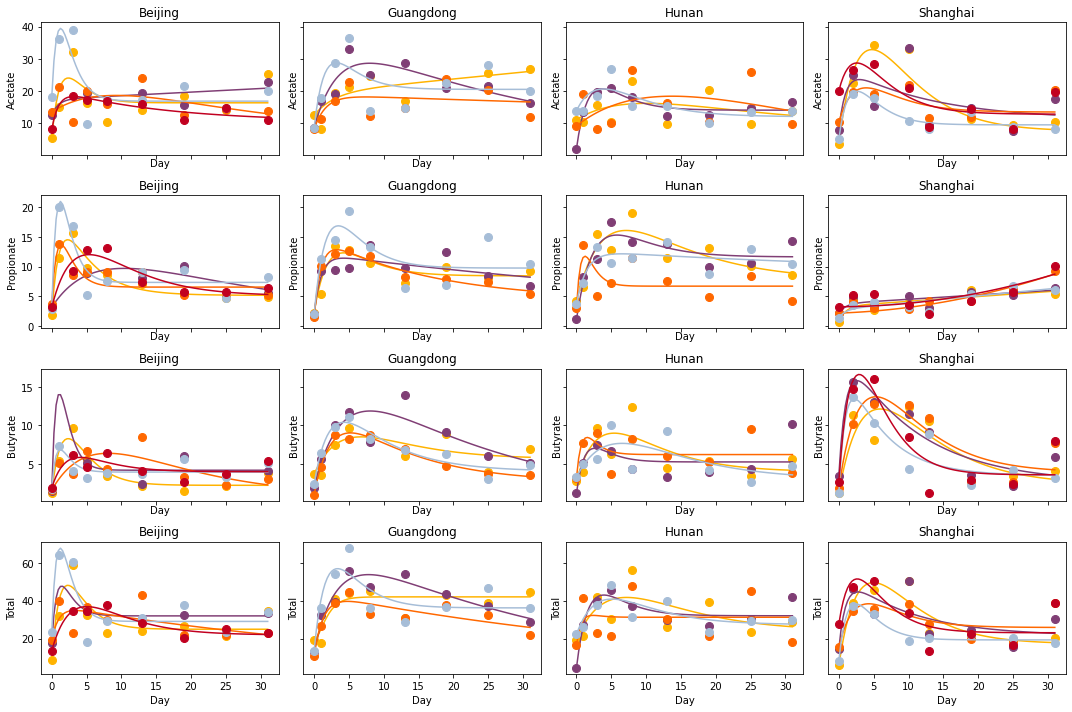

In [43]:
fig, ax = plt.subplots(figsize=(15, 10), nrows=4, ncols=4, sharex=True, sharey='row')
df_best_fit = pd.read_excel('best_fit_parameters_inulin_r2_fixedIC.xlsx', index_col=0)

df_meta_scfa_inulin = df_meta_scfa[df_meta_scfa.Diet=='Inulin']
colors = ['#FFB300', # Vivid Yellow,
          '#803E75', # Strong Purple
          '#FF6800', # Vivid Orange
          '#A6BDD7', # Very Light Blue
          '#C10020'] # Vivid Red'
for i, scfa_ in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j, vendor_ in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
        curr_df = df_meta_scfa_inulin[df_meta_scfa_inulin.Vendor==vendor_]
        for k, mice_ in enumerate(set(curr_df.MiceID)):
            curr_df2 = curr_df[curr_df.MiceID==mice_].sort_values(by='Day')
            
            # get X and Y data
            xdata = np.array(curr_df2.Day)
            ydata = np.array(curr_df2[scfa_])
            ax[i,j].plot(xdata, ydata, marker='o', linestyle = 'None', markersize=8, color=colors[k])

            xdata_dense = np.linspace(0,31,100)
            best_sol_over = df_best_fit.loc[(df_best_fit.MiceID==mice_)&(df_best_fit.SCFA==scfa_), ['k1','k2','D','H','Ai']].values[0]
            ypred = overdampling(best_sol_over, xdata_dense)
            ax[i,j].plot(xdata_dense, ypred, color=colors[k])
            ax[i,j].set_title(vendor_)
            ax[i,j].set_xlabel('Day')
            ax[i,j].set_ylabel(scfa_)
                
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("harmonic_fitting_scfa_inulin_fixedIC.svg", format="svg")

# Plot harmonic fitting for cellulose mice

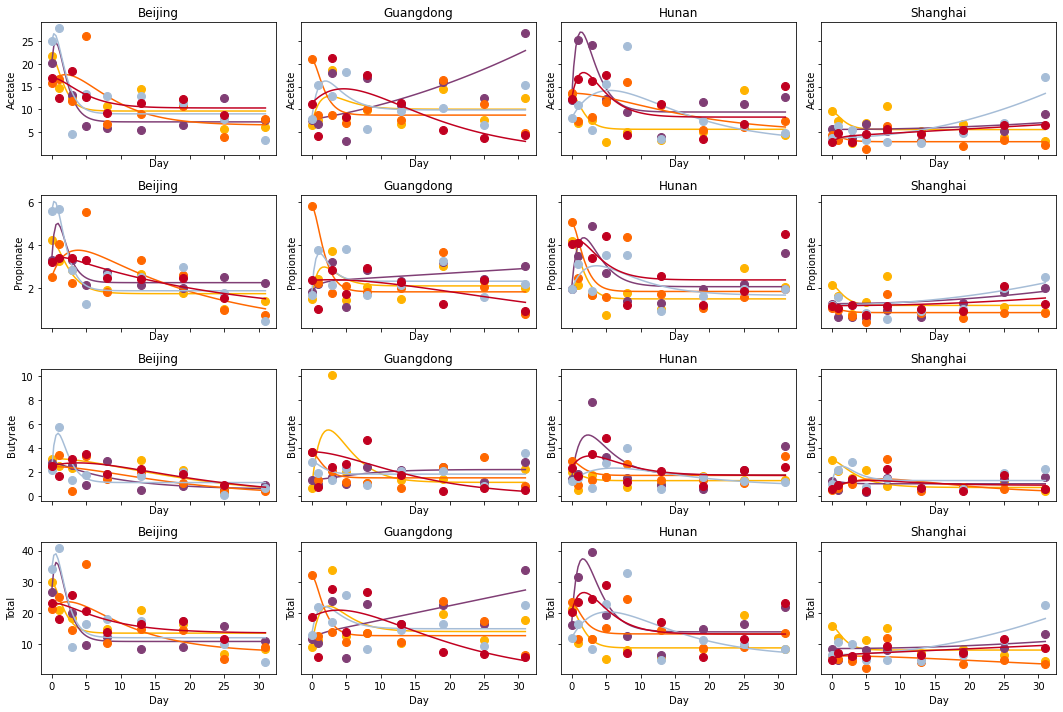

In [44]:
fig, ax = plt.subplots(figsize=(15, 10), nrows=4, ncols=4, sharex=True, sharey='row')
df_best_fit = pd.read_excel('best_fit_parameters_cellulose_r2_fixedIC.xlsx', index_col=0)

df_meta_scfa_inulin = df_meta_scfa[df_meta_scfa.Diet=='Control']
colors = ['#FFB300', # Vivid Yellow,
          '#803E75', # Strong Purple
          '#FF6800', # Vivid Orange
          '#A6BDD7', # Very Light Blue
          '#C10020'] # Vivid Red'
for i, scfa_ in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j, vendor_ in enumerate(['Beijing','Guangdong','Hunan','Shanghai']):
        curr_df = df_meta_scfa_inulin[df_meta_scfa_inulin.Vendor==vendor_]
        for k, mice_ in enumerate(set(curr_df.MiceID)):
            curr_df2 = curr_df[curr_df.MiceID==mice_].sort_values(by='Day')
            
            # get X and Y data
            xdata = np.array(curr_df2.Day)
            ydata = np.array(curr_df2[scfa_])
            ax[i,j].plot(xdata, ydata, marker='o', linestyle = 'None', markersize=8, color=colors[k])

            xdata_dense = np.linspace(0,31,100)
            best_sol_over = df_best_fit.loc[(df_best_fit.MiceID==mice_)&(df_best_fit.SCFA==scfa_), ['k1','k2','D','H','Ai']].values[0]
            ypred = overdampling(best_sol_over, xdata_dense)
            ax[i,j].plot(xdata_dense, ypred, color=colors[k])
            ax[i,j].set_title(vendor_)
            ax[i,j].set_xlabel('Day')
            ax[i,j].set_ylabel(scfa_)
                
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("harmonic_fitting_scfa_cellulose_fixedIC.svg", format="svg")

# Analyze individualized response for each individual parameters

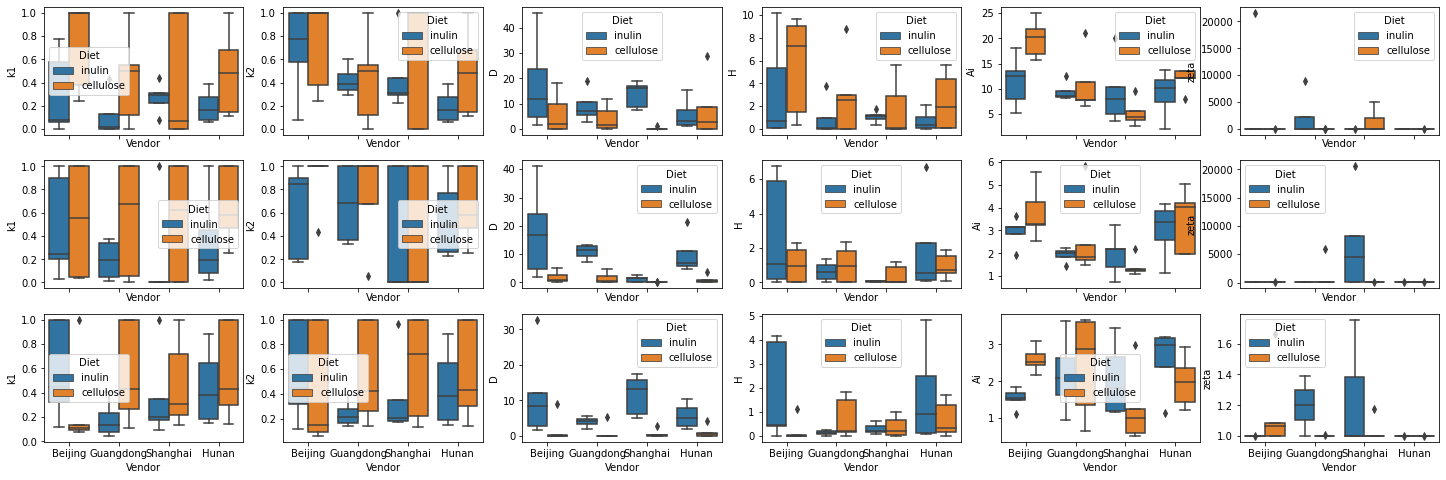

In [35]:
df_best_fit_inulin = pd.read_excel('best_fit_parameters_inulin_r2_fixedIC.xlsx', index_col=0)
df_best_fit_inulin['Diet'] = 'inulin'
df_best_fit_cellulose = pd.read_excel('best_fit_parameters_cellulose_r2_fixedIC.xlsx', index_col=0)
df_best_fit_cellulose['Diet'] = 'cellulose'
df_best_fit = pd.concat([df_best_fit_inulin, df_best_fit_cellulose], ignore_index=True)



fig, ax = plt.subplots(figsize=(25, 8), nrows=3, ncols=6, sharex=True)

for i,scfa in enumerate(['Acetate','Propionate','Butyrate','Total']):
    for j,params in enumerate(['k1','k2','D','H','Ai','zeta']):
        df_tmp = df_best_fit[df_best_fit.SCFA==scfa]
        sns.boxplot(x='Vendor', y=params, hue='Diet', data=df_tmp, ax=ax[i,j])
